In [4]:
import torch.nn as nn
import torch
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
# class Hardswish(nn.Module):  # alternative to nn.Hardswish() for export
#     @staticmethod
#     def forward(x):
#         # return x * F.hardsigmoid(x)
#         return x * F.hardtanh(x + 3, 0., 6.) / 6.

In [5]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [13]:
def __init__(self, params):
    super(Net, self).__init__()
    
    C_in,H_in,W_in=params["input_shape"] 
    self.dropout_rate=params["drop_rate"] 
    self.num_fc1 = params["num_fc1"]

    mobile_v3 =  timm.create_model('mobilenetv3_large_100', pretrained=True, scriptable=True)
    
    in_features = mobile_v3.classifier.in_features
    
    mobile_v3.classifier = nn.Linear(in_features, self.num_fc1)
    
    self.backbone = nn.Sequential(
                    mobile_v3,
                    nn.BatchNorm1d(num_features=self.num_fc1),
                    nn.ReLU()
    )
    
    self.gender_head = nn.Sequential(
                            nn.Dropout(p=self.dropout_rate),
                            nn.Linear(self.num_fc1, 1),
                            nn.Sigmoid()
    )
    
    self.age_head = nn.Sequential(
                    nn.Linear(self.num_fc1, 1)
    )

In [14]:
def forward(self, x):
    x = self.backbone(x)  
    
    gender = self.gender_head(x)
    age = self.age_head(x)
    
    return age, gender

In [15]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,224,224),
        "drop_rate" : 0.2,
        "num_fc1" : 512,
    }

model = Net(params_model)

# def replace_nnHar_to_SiLU(model):
#     for child_name, child in model.named_children():
#         if isinstance(child, nn.SiLU):
#             setattr(model, child_name, SiLU())
#         else:
#             replace_nnSiLU_to_SiLU(child)
            
# replace_nnSiLU_to_SiLU(model)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Let's use 4 GPUs!


In [16]:
checkpoint = torch.load('../models/exp_2020_12_09-09_45_03/best_checkpoints.bin')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
if isinstance(model, torch.nn.DataParallel):
        model = model.module

In [18]:
model.eval()

Net(
  (backbone): Sequential(
    (0): MobileNetV3(
      (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): HardSwishJit()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU(inplace=True)
            (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act2): Identity()
          )
        )
        (1): Sequential(
          (0): InvertedResidual(
            (conv_pw): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [19]:
import torch.onnx

In [21]:
# Input to the model
batch_size = 1    # just a random number

x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch_out = model(x)

ONNX_PATH = '../models/age_gender_mobilenet.onnx'

# Export the model
torch.onnx.export(
                  model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  f = ONNX_PATH,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  verbose = False,
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output_age', 'output_gender'] # the model's output names
                 )

RuntimeError: ONNX export failed: Couldn't export operator aten::flatten

Defined at:
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/mobilenetv3.py(141): forward
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/module.py(709): _slow_forward
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/module.py(725): _call_impl
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/container.py(117): forward
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/module.py(709): _slow_forward
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/module.py(725): _call_impl
<ipython-input-14-b8c514028c28>(2): forward
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/module.py(709): _slow_forward
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/module.py(725): _call_impl
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/jit/_trace.py(116): wrapper
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/jit/_trace.py(125): forward
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/module.py(727): _call_impl
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/jit/_trace.py(1148): _get_trace_graph
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/onnx/utils.py(342): _trace_and_get_graph_from_model
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/onnx/utils.py(379): _create_jit_graph
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/onnx/utils.py(409): _model_to_graph
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/onnx/utils.py(632): _export
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/onnx/utils.py(85): export
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/onnx/__init__.py(225): export
<ipython-input-21-f07c5c3db454>(10): <module>
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3418): run_code
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3338): run_ast_nodes
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/IPython/core/interactiveshell.py(3146): run_cell_async
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/IPython/core/async_helpers.py(68): _pseudo_sync_runner
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/IPython/core/interactiveshell.py(2923): _run_cell
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/IPython/core/interactiveshell.py(2877): run_cell
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/ipykernel/zmqshell.py(536): run_cell
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/ipykernel/ipkernel.py(306): do_execute
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/gen.py(209): wrapper
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/ipykernel/kernelbase.py(543): execute_request
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/gen.py(209): wrapper
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/ipykernel/kernelbase.py(268): dispatch_shell
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/gen.py(209): wrapper
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/ipykernel/kernelbase.py(365): process_one
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/gen.py(748): run
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/gen.py(787): inner
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/ioloop.py(743): _run_callback
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/ioloop.py(690): <lambda>
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/asyncio/events.py(81): _run
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/asyncio/base_events.py(1859): _run_once
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/asyncio/base_events.py(570): run_forever
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/tornado/platform/asyncio.py(149): start
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/ipykernel/kernelapp.py(612): start
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/traitlets/config/application.py(845): launch_instance
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/ipykernel_launcher.py(16): <module>
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/runpy.py(86): _run_code
/home/anhduy/anaconda3/envs/age_gender/lib/python3.8/runpy.py(193): _run_module_as_main


Graph we tried to export:
graph(%input : Float(1:150528, 3:50176, 224:224, 224:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.0.se.conv_reduce.weight : Float(24:72, 72:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.0.se.conv_reduce.bias : Float(24:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.0.se.conv_expand.weight : Float(72:24, 24:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.0.se.conv_expand.bias : Float(72:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.1.se.conv_reduce.weight : Float(32:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.1.se.conv_reduce.bias : Float(32:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.1.se.conv_expand.weight : Float(120:32, 32:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.1.se.conv_expand.bias : Float(120:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.2.se.conv_reduce.weight : Float(32:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.2.se.conv_reduce.bias : Float(32:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.2.se.conv_expand.weight : Float(120:32, 32:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.2.2.se.conv_expand.bias : Float(120:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.0.se.conv_reduce.weight : Float(120:480, 480:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.0.se.conv_reduce.bias : Float(120:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.0.se.conv_expand.weight : Float(480:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.0.se.conv_expand.bias : Float(480:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.1.se.conv_reduce.weight : Float(168:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.1.se.conv_reduce.bias : Float(168:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.1.se.conv_expand.weight : Float(672:168, 168:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.4.1.se.conv_expand.bias : Float(672:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.0.se.conv_reduce.weight : Float(168:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.0.se.conv_reduce.bias : Float(168:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.0.se.conv_expand.weight : Float(672:168, 168:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.0.se.conv_expand.bias : Float(672:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.1.se.conv_reduce.weight : Float(240:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.1.se.conv_reduce.bias : Float(240:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.1.se.conv_expand.weight : Float(960:240, 240:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.1.se.conv_expand.bias : Float(960:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.2.se.conv_reduce.weight : Float(240:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.2.se.conv_reduce.bias : Float(240:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.2.se.conv_expand.weight : Float(960:240, 240:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.blocks.5.2.se.conv_expand.bias : Float(960:1, requires_grad=1, device=cpu),
      %backbone.0.conv_head.weight : Float(1280:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu),
      %backbone.0.conv_head.bias : Float(1280:1, requires_grad=1, device=cpu),
      %backbone.0.classifier.weight : Float(512:1280, 1280:1, requires_grad=1, device=cpu),
      %backbone.0.classifier.bias : Float(512:1, requires_grad=1, device=cpu),
      %backbone.1.weight : Float(512:1, requires_grad=1, device=cpu),
      %backbone.1.bias : Float(512:1, requires_grad=1, device=cpu),
      %backbone.1.running_mean : Float(512:1, requires_grad=0, device=cpu),
      %backbone.1.running_var : Float(512:1, requires_grad=0, device=cpu),
      %gender_head.1.weight : Float(1:512, 512:1, requires_grad=1, device=cpu),
      %gender_head.1.bias : Float(1:1, requires_grad=1, device=cpu),
      %age_head.0.weight : Float(1:512, 512:1, requires_grad=1, device=cpu),
      %age_head.0.bias : Float(1:1, requires_grad=1, device=cpu),
      %753 : Float(16:27, 3:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %754 : Float(16:1, requires_grad=0, device=cpu),
      %756 : Float(16:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %757 : Float(16:1, requires_grad=0, device=cpu),
      %759 : Float(16:16, 16:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %760 : Float(16:1, requires_grad=0, device=cpu),
      %762 : Float(64:16, 16:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %763 : Float(64:1, requires_grad=0, device=cpu),
      %765 : Float(64:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %766 : Float(64:1, requires_grad=0, device=cpu),
      %768 : Float(24:64, 64:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %769 : Float(24:1, requires_grad=0, device=cpu),
      %771 : Float(72:24, 24:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %772 : Float(72:1, requires_grad=0, device=cpu),
      %774 : Float(72:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %775 : Float(72:1, requires_grad=0, device=cpu),
      %777 : Float(24:72, 72:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %778 : Float(24:1, requires_grad=0, device=cpu),
      %780 : Float(72:24, 24:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %781 : Float(72:1, requires_grad=0, device=cpu),
      %783 : Float(72:25, 1:25, 5:5, 5:1, requires_grad=0, device=cpu),
      %784 : Float(72:1, requires_grad=0, device=cpu),
      %786 : Float(40:72, 72:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %787 : Float(40:1, requires_grad=0, device=cpu),
      %789 : Float(120:40, 40:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %790 : Float(120:1, requires_grad=0, device=cpu),
      %792 : Float(120:25, 1:25, 5:5, 5:1, requires_grad=0, device=cpu),
      %793 : Float(120:1, requires_grad=0, device=cpu),
      %795 : Float(40:120, 120:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %796 : Float(40:1, requires_grad=0, device=cpu),
      %798 : Float(120:40, 40:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %799 : Float(120:1, requires_grad=0, device=cpu),
      %801 : Float(120:25, 1:25, 5:5, 5:1, requires_grad=0, device=cpu),
      %802 : Float(120:1, requires_grad=0, device=cpu),
      %804 : Float(40:120, 120:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %805 : Float(40:1, requires_grad=0, device=cpu),
      %807 : Float(240:40, 40:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %808 : Float(240:1, requires_grad=0, device=cpu),
      %810 : Float(240:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %811 : Float(240:1, requires_grad=0, device=cpu),
      %813 : Float(80:240, 240:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %814 : Float(80:1, requires_grad=0, device=cpu),
      %816 : Float(200:80, 80:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %817 : Float(200:1, requires_grad=0, device=cpu),
      %819 : Float(200:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %820 : Float(200:1, requires_grad=0, device=cpu),
      %822 : Float(80:200, 200:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %823 : Float(80:1, requires_grad=0, device=cpu),
      %825 : Float(184:80, 80:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %826 : Float(184:1, requires_grad=0, device=cpu),
      %828 : Float(184:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %829 : Float(184:1, requires_grad=0, device=cpu),
      %831 : Float(80:184, 184:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %832 : Float(80:1, requires_grad=0, device=cpu),
      %834 : Float(184:80, 80:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %835 : Float(184:1, requires_grad=0, device=cpu),
      %837 : Float(184:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %838 : Float(184:1, requires_grad=0, device=cpu),
      %840 : Float(80:184, 184:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %841 : Float(80:1, requires_grad=0, device=cpu),
      %843 : Float(480:80, 80:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %844 : Float(480:1, requires_grad=0, device=cpu),
      %846 : Float(480:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %847 : Float(480:1, requires_grad=0, device=cpu),
      %849 : Float(112:480, 480:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %850 : Float(112:1, requires_grad=0, device=cpu),
      %852 : Float(672:112, 112:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %853 : Float(672:1, requires_grad=0, device=cpu),
      %855 : Float(672:9, 1:9, 3:3, 3:1, requires_grad=0, device=cpu),
      %856 : Float(672:1, requires_grad=0, device=cpu),
      %858 : Float(112:672, 672:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %859 : Float(112:1, requires_grad=0, device=cpu),
      %861 : Float(672:112, 112:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %862 : Float(672:1, requires_grad=0, device=cpu),
      %864 : Float(672:25, 1:25, 5:5, 5:1, requires_grad=0, device=cpu),
      %865 : Float(672:1, requires_grad=0, device=cpu),
      %867 : Float(160:672, 672:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %868 : Float(160:1, requires_grad=0, device=cpu),
      %870 : Float(960:160, 160:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %871 : Float(960:1, requires_grad=0, device=cpu),
      %873 : Float(960:25, 1:25, 5:5, 5:1, requires_grad=0, device=cpu),
      %874 : Float(960:1, requires_grad=0, device=cpu),
      %876 : Float(160:960, 960:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %877 : Float(160:1, requires_grad=0, device=cpu),
      %879 : Float(960:160, 160:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %880 : Float(960:1, requires_grad=0, device=cpu),
      %882 : Float(960:25, 1:25, 5:5, 5:1, requires_grad=0, device=cpu),
      %883 : Float(960:1, requires_grad=0, device=cpu),
      %885 : Float(160:960, 960:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %886 : Float(160:1, requires_grad=0, device=cpu),
      %888 : Float(960:160, 160:1, 1:1, 1:1, requires_grad=0, device=cpu),
      %889 : Float(960:1, requires_grad=0, device=cpu)):
  %752 : Float(1:200704, 16:12544, 112:112, 112:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%input, %753, %754)
  %324 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %325 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %326 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %327 : FloatTensor = onnx::Add(%752, %326) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %328 : Tensor = onnx::Clip(%327, %324, %325) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %329 : Tensor = onnx::Cast[to=11](%328)
  %330 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %331 : DoubleTensor = onnx::Div(%329, %330) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %332 : FloatTensor = onnx::Cast[to=1](%331)
  %333 : FloatTensor = onnx::Mul(%752, %332) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %755 : Float(1:200704, 16:12544, 112:112, 112:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=16, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%333, %756, %757)
  %336 : Float(1:200704, 16:12544, 112:112, 112:1, requires_grad=1, device=cpu) = onnx::Relu(%755) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %758 : Float(1:200704, 16:12544, 112:112, 112:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%336, %759, %760)
  %339 : Float(1:200704, 16:12544, 112:112, 112:1, requires_grad=1, device=cpu) = onnx::Add(%758, %333)
  %761 : Float(1:802816, 64:12544, 112:112, 112:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%339, %762, %763)
  %342 : Float(1:802816, 64:12544, 112:112, 112:1, requires_grad=1, device=cpu) = onnx::Relu(%761) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %764 : Float(1:200704, 64:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=64, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%342, %765, %766)
  %345 : Float(1:200704, 64:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Relu(%764) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %767 : Float(1:75264, 24:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%345, %768, %769)
  %770 : Float(1:225792, 72:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%767, %771, %772)
  %350 : Float(1:225792, 72:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Relu(%770) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %773 : Float(1:225792, 72:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=72, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%350, %774, %775)
  %353 : Float(1:225792, 72:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Relu(%773) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %776 : Float(1:75264, 24:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%353, %777, %778)
  %356 : Float(1:75264, 24:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Add(%776, %767)
  %779 : Float(1:225792, 72:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%356, %780, %781)
  %359 : Float(1:225792, 72:3136, 56:56, 56:1, requires_grad=1, device=cpu) = onnx::Relu(%779) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %782 : Float(1:56448, 72:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=72, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[2, 2]](%359, %783, %784)
  %362 : Float(1:56448, 72:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Relu(%782) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %363 : Float(1:72, 72:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%362) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %364 : Float(1:24, 24:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%363, %backbone.0.blocks.2.0.se.conv_reduce.weight, %backbone.0.blocks.2.0.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %365 : Float(1:24, 24:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%364) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %366 : Float(1:72, 72:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%365, %backbone.0.blocks.2.0.se.conv_expand.weight, %backbone.0.blocks.2.0.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %367 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %368 : Float(1:72, 72:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%366, %367)
  %369 : Tensor = onnx::Constant[value={0}]()
  %370 : Tensor = onnx::Constant[value={6}]()
  %371 : Float(1:72, 72:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%368, %369, %370) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %372 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %373 : Float(1:72, 72:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%371, %372)
  %374 : Float(1:56448, 72:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Mul(%362, %373) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %785 : Float(1:31360, 40:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%374, %786, %787)
  %788 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%785, %789, %790)
  %379 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Relu(%788) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %791 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%379, %792, %793)
  %382 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Relu(%791) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %383 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%382) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %384 : Float(1:32, 32:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%383, %backbone.0.blocks.2.1.se.conv_reduce.weight, %backbone.0.blocks.2.1.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %385 : Float(1:32, 32:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%384) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %386 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%385, %backbone.0.blocks.2.1.se.conv_expand.weight, %backbone.0.blocks.2.1.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %387 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %388 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%386, %387)
  %389 : Tensor = onnx::Constant[value={0}]()
  %390 : Tensor = onnx::Constant[value={6}]()
  %391 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%388, %389, %390) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %392 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %393 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%391, %392)
  %394 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Mul(%382, %393) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %794 : Float(1:31360, 40:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%394, %795, %796)
  %397 : Float(1:31360, 40:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Add(%794, %785)
  %797 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%397, %798, %799)
  %400 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Relu(%797) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %800 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=120, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%400, %801, %802)
  %403 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Relu(%800) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %404 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%403) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %405 : Float(1:32, 32:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%404, %backbone.0.blocks.2.2.se.conv_reduce.weight, %backbone.0.blocks.2.2.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %406 : Float(1:32, 32:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%405) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %407 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%406, %backbone.0.blocks.2.2.se.conv_expand.weight, %backbone.0.blocks.2.2.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %408 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %409 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%407, %408)
  %410 : Tensor = onnx::Constant[value={0}]()
  %411 : Tensor = onnx::Constant[value={6}]()
  %412 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%409, %410, %411) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %413 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %414 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%412, %413)
  %415 : Float(1:94080, 120:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Mul(%403, %414) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %803 : Float(1:31360, 40:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%415, %804, %805)
  %418 : Float(1:31360, 40:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Add(%803, %397)
  %806 : Float(1:188160, 240:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%418, %807, %808)
  %421 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %422 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %423 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %424 : FloatTensor = onnx::Add(%806, %423) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %425 : Tensor = onnx::Clip(%424, %421, %422) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %426 : Tensor = onnx::Cast[to=11](%425)
  %427 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %428 : DoubleTensor = onnx::Div(%426, %427) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %429 : FloatTensor = onnx::Cast[to=1](%428)
  %430 : FloatTensor = onnx::Mul(%806, %429) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %809 : Float(1:47040, 240:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=240, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[2, 2]](%430, %810, %811)
  %433 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %434 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %435 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %436 : FloatTensor = onnx::Add(%809, %435) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %437 : Tensor = onnx::Clip(%436, %433, %434) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %438 : Tensor = onnx::Cast[to=11](%437)
  %439 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %440 : DoubleTensor = onnx::Div(%438, %439) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %441 : FloatTensor = onnx::Cast[to=1](%440)
  %442 : FloatTensor = onnx::Mul(%809, %441) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %812 : Float(1:15680, 80:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%442, %813, %814)
  %815 : Float(1:39200, 200:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%812, %816, %817)
  %447 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %448 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %449 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %450 : FloatTensor = onnx::Add(%815, %449) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %451 : Tensor = onnx::Clip(%450, %447, %448) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %452 : Tensor = onnx::Cast[to=11](%451)
  %453 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %454 : DoubleTensor = onnx::Div(%452, %453) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %455 : FloatTensor = onnx::Cast[to=1](%454)
  %456 : FloatTensor = onnx::Mul(%815, %455) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %818 : Float(1:39200, 200:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=200, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%456, %819, %820)
  %459 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %460 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %461 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %462 : FloatTensor = onnx::Add(%818, %461) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %463 : Tensor = onnx::Clip(%462, %459, %460) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %464 : Tensor = onnx::Cast[to=11](%463)
  %465 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %466 : DoubleTensor = onnx::Div(%464, %465) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %467 : FloatTensor = onnx::Cast[to=1](%466)
  %468 : FloatTensor = onnx::Mul(%818, %467) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %821 : Float(1:15680, 80:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%468, %822, %823)
  %471 : Float(1:15680, 80:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Add(%821, %812)
  %824 : Float(1:36064, 184:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%471, %825, %826)
  %474 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %475 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %476 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %477 : FloatTensor = onnx::Add(%824, %476) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %478 : Tensor = onnx::Clip(%477, %474, %475) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %479 : Tensor = onnx::Cast[to=11](%478)
  %480 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %481 : DoubleTensor = onnx::Div(%479, %480) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %482 : FloatTensor = onnx::Cast[to=1](%481)
  %483 : FloatTensor = onnx::Mul(%824, %482) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %827 : Float(1:36064, 184:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=184, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%483, %828, %829)
  %486 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %487 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %488 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %489 : FloatTensor = onnx::Add(%827, %488) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %490 : Tensor = onnx::Clip(%489, %486, %487) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %491 : Tensor = onnx::Cast[to=11](%490)
  %492 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %493 : DoubleTensor = onnx::Div(%491, %492) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %494 : FloatTensor = onnx::Cast[to=1](%493)
  %495 : FloatTensor = onnx::Mul(%827, %494) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %830 : Float(1:15680, 80:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%495, %831, %832)
  %498 : Float(1:15680, 80:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Add(%830, %471)
  %833 : Float(1:36064, 184:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%498, %834, %835)
  %501 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %502 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %503 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %504 : FloatTensor = onnx::Add(%833, %503) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %505 : Tensor = onnx::Clip(%504, %501, %502) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %506 : Tensor = onnx::Cast[to=11](%505)
  %507 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %508 : DoubleTensor = onnx::Div(%506, %507) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %509 : FloatTensor = onnx::Cast[to=1](%508)
  %510 : FloatTensor = onnx::Mul(%833, %509) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %836 : Float(1:36064, 184:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=184, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%510, %837, %838)
  %513 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %514 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %515 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %516 : FloatTensor = onnx::Add(%836, %515) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %517 : Tensor = onnx::Clip(%516, %513, %514) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %518 : Tensor = onnx::Cast[to=11](%517)
  %519 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %520 : DoubleTensor = onnx::Div(%518, %519) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %521 : FloatTensor = onnx::Cast[to=1](%520)
  %522 : FloatTensor = onnx::Mul(%836, %521) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %839 : Float(1:15680, 80:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%522, %840, %841)
  %525 : Float(1:15680, 80:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Add(%839, %498)
  %842 : Float(1:94080, 480:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%525, %843, %844)
  %528 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %529 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %530 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %531 : FloatTensor = onnx::Add(%842, %530) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %532 : Tensor = onnx::Clip(%531, %528, %529) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %533 : Tensor = onnx::Cast[to=11](%532)
  %534 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %535 : DoubleTensor = onnx::Div(%533, %534) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %536 : FloatTensor = onnx::Cast[to=1](%535)
  %537 : FloatTensor = onnx::Mul(%842, %536) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %845 : Float(1:94080, 480:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=480, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%537, %846, %847)
  %540 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %541 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %542 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %543 : FloatTensor = onnx::Add(%845, %542) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %544 : Tensor = onnx::Clip(%543, %540, %541) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %545 : Tensor = onnx::Cast[to=11](%544)
  %546 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %547 : DoubleTensor = onnx::Div(%545, %546) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %548 : FloatTensor = onnx::Cast[to=1](%547)
  %549 : FloatTensor = onnx::Mul(%845, %548) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %550 : Float(1:480, 480:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%549) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %551 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%550, %backbone.0.blocks.4.0.se.conv_reduce.weight, %backbone.0.blocks.4.0.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %552 : Float(1:120, 120:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%551) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %553 : Float(1:480, 480:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%552, %backbone.0.blocks.4.0.se.conv_expand.weight, %backbone.0.blocks.4.0.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %554 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %555 : Float(1:480, 480:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%553, %554)
  %556 : Tensor = onnx::Constant[value={0}]()
  %557 : Tensor = onnx::Constant[value={6}]()
  %558 : Float(1:480, 480:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%555, %556, %557) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %559 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %560 : Float(1:480, 480:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%558, %559)
  %561 : Float(1:94080, 480:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Mul(%549, %560) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %848 : Float(1:21952, 112:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%561, %849, %850)
  %851 : Float(1:131712, 672:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%848, %852, %853)
  %566 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %567 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %568 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %569 : FloatTensor = onnx::Add(%851, %568) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %570 : Tensor = onnx::Clip(%569, %566, %567) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %571 : Tensor = onnx::Cast[to=11](%570)
  %572 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %573 : DoubleTensor = onnx::Div(%571, %572) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %574 : FloatTensor = onnx::Cast[to=1](%573)
  %575 : FloatTensor = onnx::Mul(%851, %574) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %854 : Float(1:131712, 672:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=672, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1]](%575, %855, %856)
  %578 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %579 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %580 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %581 : FloatTensor = onnx::Add(%854, %580) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %582 : Tensor = onnx::Clip(%581, %578, %579) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %583 : Tensor = onnx::Cast[to=11](%582)
  %584 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %585 : DoubleTensor = onnx::Div(%583, %584) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %586 : FloatTensor = onnx::Cast[to=1](%585)
  %587 : FloatTensor = onnx::Mul(%854, %586) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %588 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%587) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %589 : Float(1:168, 168:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%588, %backbone.0.blocks.4.1.se.conv_reduce.weight, %backbone.0.blocks.4.1.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %590 : Float(1:168, 168:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%589) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %591 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%590, %backbone.0.blocks.4.1.se.conv_expand.weight, %backbone.0.blocks.4.1.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %592 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %593 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%591, %592)
  %594 : Tensor = onnx::Constant[value={0}]()
  %595 : Tensor = onnx::Constant[value={6}]()
  %596 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%593, %594, %595) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %597 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %598 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%596, %597)
  %599 : Float(1:131712, 672:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Mul(%587, %598) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %857 : Float(1:21952, 112:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%599, %858, %859)
  %602 : Float(1:21952, 112:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Add(%857, %848)
  %860 : Float(1:131712, 672:196, 14:14, 14:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%602, %861, %862)
  %605 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %606 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %607 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %608 : FloatTensor = onnx::Add(%860, %607) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %609 : Tensor = onnx::Clip(%608, %605, %606) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %610 : Tensor = onnx::Cast[to=11](%609)
  %611 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %612 : DoubleTensor = onnx::Div(%610, %611) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %613 : FloatTensor = onnx::Cast[to=1](%612)
  %614 : FloatTensor = onnx::Mul(%860, %613) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %863 : Float(1:32928, 672:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=672, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[2, 2]](%614, %864, %865)
  %617 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %618 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %619 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %620 : FloatTensor = onnx::Add(%863, %619) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %621 : Tensor = onnx::Clip(%620, %617, %618) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %622 : Tensor = onnx::Cast[to=11](%621)
  %623 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %624 : DoubleTensor = onnx::Div(%622, %623) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %625 : FloatTensor = onnx::Cast[to=1](%624)
  %626 : FloatTensor = onnx::Mul(%863, %625) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %627 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%626) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %628 : Float(1:168, 168:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%627, %backbone.0.blocks.5.0.se.conv_reduce.weight, %backbone.0.blocks.5.0.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %629 : Float(1:168, 168:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%628) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %630 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%629, %backbone.0.blocks.5.0.se.conv_expand.weight, %backbone.0.blocks.5.0.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %631 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %632 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%630, %631)
  %633 : Tensor = onnx::Constant[value={0}]()
  %634 : Tensor = onnx::Constant[value={6}]()
  %635 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%632, %633, %634) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %636 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %637 : Float(1:672, 672:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%635, %636)
  %638 : Float(1:32928, 672:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Mul(%626, %637) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %866 : Float(1:7840, 160:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%638, %867, %868)
  %869 : Float(1:47040, 960:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%866, %870, %871)
  %643 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %644 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %645 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %646 : FloatTensor = onnx::Add(%869, %645) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %647 : Tensor = onnx::Clip(%646, %643, %644) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %648 : Tensor = onnx::Cast[to=11](%647)
  %649 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %650 : DoubleTensor = onnx::Div(%648, %649) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %651 : FloatTensor = onnx::Cast[to=1](%650)
  %652 : FloatTensor = onnx::Mul(%869, %651) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %872 : Float(1:47040, 960:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=960, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%652, %873, %874)
  %655 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %656 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %657 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %658 : FloatTensor = onnx::Add(%872, %657) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %659 : Tensor = onnx::Clip(%658, %655, %656) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %660 : Tensor = onnx::Cast[to=11](%659)
  %661 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %662 : DoubleTensor = onnx::Div(%660, %661) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %663 : FloatTensor = onnx::Cast[to=1](%662)
  %664 : FloatTensor = onnx::Mul(%872, %663) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %665 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%664) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %666 : Float(1:240, 240:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%665, %backbone.0.blocks.5.1.se.conv_reduce.weight, %backbone.0.blocks.5.1.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %667 : Float(1:240, 240:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%666) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %668 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%667, %backbone.0.blocks.5.1.se.conv_expand.weight, %backbone.0.blocks.5.1.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %669 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %670 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%668, %669)
  %671 : Tensor = onnx::Constant[value={0}]()
  %672 : Tensor = onnx::Constant[value={6}]()
  %673 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%670, %671, %672) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %674 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %675 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%673, %674)
  %676 : Float(1:47040, 960:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Mul(%664, %675) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %875 : Float(1:7840, 160:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%676, %876, %877)
  %679 : Float(1:7840, 160:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Add(%875, %866)
  %878 : Float(1:47040, 960:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%679, %879, %880)
  %682 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %683 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %684 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %685 : FloatTensor = onnx::Add(%878, %684) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %686 : Tensor = onnx::Clip(%685, %682, %683) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %687 : Tensor = onnx::Cast[to=11](%686)
  %688 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %689 : DoubleTensor = onnx::Div(%687, %688) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %690 : FloatTensor = onnx::Cast[to=1](%689)
  %691 : FloatTensor = onnx::Mul(%878, %690) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %881 : Float(1:47040, 960:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=960, kernel_shape=[5, 5], pads=[2, 2, 2, 2], strides=[1, 1]](%691, %882, %883)
  %694 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %695 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %696 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %697 : FloatTensor = onnx::Add(%881, %696) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %698 : Tensor = onnx::Clip(%697, %694, %695) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %699 : Tensor = onnx::Cast[to=11](%698)
  %700 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %701 : DoubleTensor = onnx::Div(%699, %700) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %702 : FloatTensor = onnx::Cast[to=1](%701)
  %703 : FloatTensor = onnx::Mul(%881, %702) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %704 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::ReduceMean[axes=[2, 3], keepdims=1](%703) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:116:0
  %705 : Float(1:240, 240:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%704, %backbone.0.blocks.5.2.se.conv_reduce.weight, %backbone.0.blocks.5.2.se.conv_reduce.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %706 : Float(1:240, 240:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Relu(%705) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1134:0
  %707 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%706, %backbone.0.blocks.5.2.se.conv_expand.weight, %backbone.0.blocks.5.2.se.conv_expand.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %708 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %709 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Add(%707, %708)
  %710 : Tensor = onnx::Constant[value={0}]()
  %711 : Tensor = onnx::Constant[value={6}]()
  %712 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Clip(%709, %710, %711) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1188:0
  %713 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %714 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Div(%712, %713)
  %715 : Float(1:47040, 960:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Mul(%703, %714) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/efficientnet_blocks.py:120:0
  %884 : Float(1:7840, 160:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%715, %885, %886)
  %718 : Float(1:7840, 160:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Add(%884, %679)
  %887 : Float(1:47040, 960:49, 7:7, 7:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%718, %888, %889)
  %721 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %722 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %723 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %724 : FloatTensor = onnx::Add(%887, %723) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %725 : Tensor = onnx::Clip(%724, %721, %722) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %726 : Tensor = onnx::Cast[to=11](%725)
  %727 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %728 : DoubleTensor = onnx::Div(%726, %727) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %729 : FloatTensor = onnx::Cast[to=1](%728)
  %730 : FloatTensor = onnx::Mul(%887, %729) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %731 : Float(1:960, 960:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::GlobalAveragePool(%730) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:936:0
  %732 : Float(1:1280, 1280:1, 1:1, 1:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[1, 1], pads=[0, 0, 0, 0], strides=[1, 1]](%731, %backbone.0.conv_head.weight, %backbone.0.conv_head.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %733 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={0}]()
  %734 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %735 : Float(requires_grad=0, device=cpu) = onnx::Constant[value={3}]()
  %736 : FloatTensor = onnx::Add(%732, %735) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %737 : Tensor = onnx::Clip(%736, %733, %734) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %738 : Tensor = onnx::Cast[to=11](%737)
  %739 : Double(requires_grad=0, device=cpu) = onnx::Constant[value={6}]()
  %740 : DoubleTensor = onnx::Div(%738, %739) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:16
  %741 : FloatTensor = onnx::Cast[to=1](%740)
  %742 : FloatTensor = onnx::Mul(%732, %741) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/layers/activations_jit.py:65:11
  %743 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={1}]()
  %744 : Long(requires_grad=0, device=cpu) = onnx::Constant[value={-1}]()
  %input.138 : Float(1:1280, 1280:1, requires_grad=1, device=cpu) = aten::flatten(%742, %743, %744) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/timm/models/mobilenetv3.py:141:0
  %746 : Float(1:512, 512:1, requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%input.138, %backbone.0.classifier.weight, %backbone.0.classifier.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1690:0
  %747 : Float(1:512, 512:1, requires_grad=1, device=cpu) = onnx::BatchNormalization[epsilon=1.0000000000000001e-05, momentum=0.90000000000000002](%746, %backbone.1.weight, %backbone.1.bias, %backbone.1.running_mean, %backbone.1.running_var) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:2056:0
  %748 : Float(1:512, 512:1, requires_grad=1, device=cpu) = onnx::Relu(%747) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:983:0
  %749 : Float(1:1, 1:1, requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%748, %gender_head.1.weight, %gender_head.1.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1690:0
  %output_gender : Float(1:1, 1:1, requires_grad=1, device=cpu) = onnx::Sigmoid(%749) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/modules/activation.py:299:0
  %output_age : Float(1:1, 1:1, requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1](%748, %age_head.0.weight, %age_head.0.bias) # /home/anhduy/anaconda3/envs/age_gender/lib/python3.8/site-packages/torch/nn/functional.py:1690:0
  return (%output_age, %output_gender)


In [ ]:
torch.__version__

In [25]:
import onnx

onnx_model = onnx.load("../models/age_gender_misnet.onnx")
onnx.checker.check_model(onnx_model)

In [26]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("../models/age_gender_misnet.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
for i, result in enumerate(torch_out):
    np.testing.assert_allclose(to_numpy(result), ort_outs[i], rtol=1e-03, atol=1e-05)
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
Exported model has been tested with ONNXRuntime, and the result looks good!


In [27]:
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
        ToTensorV2(),
    ])

df = pd.read_csv("/home/Data/all/testing.csv")
img = cv2.imread(df['file_name'][500], cv2.IMREAD_COLOR)

out = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')

img /= 255.0

img = get_val_transforms()(image = img)['image']

age, gender = df['age'][0], df['gender'][0]

img = torch.unsqueeze(img, 0)

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_age = ort_outs[0]
img_out_gd = ort_outs[1]

Text(0.5, 1.0, 'Age :21-[[25.087376]], Gender: 0-[[0.3627907]]')

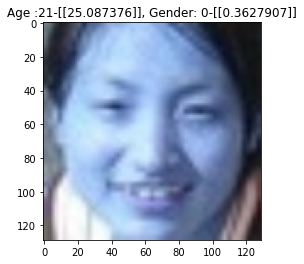

In [28]:
plt.imshow(out)
plt.title(f'Age :{age}-{img_out_age}, Gender: {gender}-{img_out_gd}')

In [29]:
from onnx_tf.backend import prepare
import onnx

ONNX_PATH = '../models/age_gender_misnet.onnx'

onnx_model = onnx.load(ONNX_PATH)

tf_rep = prepare(onnx_model, logging_level ='DEBUG')

# Input nodes to the model
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)

2021-01-13 11:15:59,561 - onnx-tf - INFO - Unknown op ConstantFill in domain `ai.onnx`.
INFO:onnx-tf:Unknown op ConstantFill in domain `ai.onnx`.
2021-01-13 11:15:59,563 - onnx-tf - INFO - Unknown op ImageScaler in domain `ai.onnx`.
INFO:onnx-tf:Unknown op ImageScaler in domain `ai.onnx`.


inputs: ['input']
outputs: ['output_age', 'output_gender']
tensor_dict:
{'838': <tf.Tensor '838:0' shape=(16, 3, 3, 3) dtype=float32>, '839': <tf.Tensor '839:0' shape=(16,) dtype=float32>, '841': <tf.Tensor '841:0' shape=(16, 1, 3, 3) dtype=float32>, '842': <tf.Tensor '842:0' shape=(16,) dtype=float32>, '844': <tf.Tensor '844:0' shape=(16, 16, 1, 1) dtype=float32>, '845': <tf.Tensor '845:0' shape=(16,) dtype=float32>, '847': <tf.Tensor '847:0' shape=(96, 1, 3, 3) dtype=float32>, '848': <tf.Tensor '848:0' shape=(96,) dtype=float32>, '850': <tf.Tensor '850:0' shape=(72, 1, 3, 3) dtype=float32>, '851': <tf.Tensor '851:0' shape=(72,) dtype=float32>, '853': <tf.Tensor '853:0' shape=(144, 24, 1, 1) dtype=float32>, '854': <tf.Tensor '854:0' shape=(144,) dtype=float32>, '856': <tf.Tensor '856:0' shape=(40, 144, 1, 1) dtype=float32>, '857': <tf.Tensor '857:0' shape=(40,) dtype=float32>, '859': <tf.Tensor '859:0' shape=(240, 40, 1, 1) dtype=float32>, '860': <tf.Tensor '860:0' shape=(240,) dtype=

In [30]:
import numpy as np
from IPython.display import display
from PIL import Image

# prepare input data
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
    ])

df = pd.read_csv("/home/Data/all/testing.csv")
img = cv2.imread(df['file_name'][500], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')

img /= 255.0

img = get_val_transforms()(image = img)['image']

output = tf_rep.run(np.transpose(np.asarray(img, dtype=np.float32)[np.newaxis ,: , :, :], (0, 3, 1, 2)))
print('Age {}, Gender {} as '.format(output[0], output[1]))

Age [[25.087465]], Gender [[0.3627599]] as 


In [31]:
tf_rep.export_graph('../models/agegender.pb')

In [33]:
import tensorflow as tf

TFLITE_PATH_V1 = '../models/age_gender_mixnet_v1.tflite'

graph_file = '../models/agegender.pb'

input_array = ['input'] # you need to change it based on your model
output_array = ['output_age', 'output_gender'] # you need to change it based on your model
print("{} -> {}".format(graph_file, TFLITE_PATH_V1))

converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
      graph_def_file=graph_file,
      input_arrays=input_array,
      output_arrays=output_array,
#       input_shapes={'input' : [1, 3, 224, 224]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops=True
converter.experimental_new_converter =True

# I had to explicitly state the ops
converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]


tflite_quant_model = converter.convert()

with open(TFLITE_PATH_V1, 'wb') as f:
    f.write(tflite_quant_model)

../models/agegender.pb -> ../models/age_gender_mixnet_v1.tflite


ConverterError: <unknown>:0: error: loc("BatchNormalization_363/mul_1"): 'tfl.fully_connected' op expect 2d filter, got 'tensor<1x512x1536xf32>'
<unknown>:0: note: loc("BatchNormalization_363/mul_1"): see current operation: %7165 = "tfl.fully_connected"(%7164, %cst_6786, %cst_6787) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<1x1536xf32>, tensor<1x512x1536xf32>, tensor<1x512xf32>) -> tensor<1x512xf32>


In [ ]:
TFLITE_PATH_V2 = '../models/age_gender_mixnet_v2.tflite'
TFLITE_PATH_V3 = '../models/age_gender_mixnet_v3.tflite'